In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Preprocess Text

In [3]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [4]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    # prep_line = prep_line.replace('-', ' ') # TODO: origin line
    prep_line = prep_line.replace('_', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    # transfrom string to char sequence
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    # transform char sequence to id sequence
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


### Dataset

In [5]:
data_path = './datasets/'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [6]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


In [7]:
def idList2Text(idList):
    text = ""
    for id in idList:
        if(id == "5427"): break
        elif(id == "5428"): text += "[UNK] "
        else: text += id2word_dict[id] + ' '
    return text.strip()

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text = idList2Text(['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5428', '5427', '5427', '5427', '5427', '5427', '5427', '5427'])
tokens = tokenizer.encode(text, add_special_tokens=True, padding='longest')

print("Original Text:", text)
print("Tokenized IDs:", tokens)
print("Token length:", len(tokens))
print("Decoded Tokens:", tokenizer.decode(tokens))

c:\Users\user\anaconda3\envs\tensorflow_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original Text: the flower shown has yellow anther red pistil and bright red petals [UNK]
Tokenized IDs: [101, 1996, 6546, 3491, 2038, 3756, 14405, 5886, 2417, 14255, 16643, 2140, 1998, 4408, 2417, 15829, 100, 102]
Token length: 18
Decoded Tokens: [CLS] the flower shown has yellow anther red pistil and bright red petals [UNK] [SEP]


### Dataset API

In [9]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    #TODO: data augmentation and normalize value to [-1, 1]
    img = (img * 2) - 1
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    # img = tf.image.random_hue(img, max_delta=0.2)    
    
    return img, caption

def dataset_generator(filenames, batch_size, data_generator):
    df = pd.read_pickle(filenames)

    captions = df['Captions'].values
    image_path = df['ImagePath'].values
    textCaptionList = []
    # imagePathList = []

    # TODO: only choose one of descriptions to train, total descriptions is 70504
    for i in range(len(captions)):
        # for j in range(len(captions[i])):
        #     textCaptionList.append(idList2Text(captions[i][j]))
        #     imagePathList.append(imagePaths[i])
        textCaptionList.append(idList2Text(random.choice(captions[i])))

    # imagePathList = np.asarray(imagePathList)

    captionList = [tokenizer.encode(text, add_special_tokens=True) for text in textCaptionList]
    max_token_length = max(len(tokens) for tokens in captionList)
    paddedCaptionList = tf.keras.preprocessing.sequence.pad_sequences(captionList, padding='post', maxlen=max_token_length)
    paddedCaptionList = np.asarray(paddedCaptionList).astype(int)

    # check whether padded caption has same length
    for pad_caption in paddedCaptionList:
        if(len(pad_caption) != max_token_length): print(len(pad_caption))
        
    print(f"Dataset size: {len(paddedCaptionList)}, Caption Length: {len(paddedCaptionList[0])}")
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert len(paddedCaptionList) == len(image_path)
    assert paddedCaptionList.dtype == int

    dataset = tf.data.Dataset.from_tensor_slices((paddedCaptionList, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(paddedCaptionList)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [10]:
# # in this competition, you have to generate image in size 64x64x3
# IMAGE_HEIGHT = 64
# IMAGE_WIDTH = 64
# IMAGE_CHANNEL = 3

# def training_data_generator(caption, image_path):
#     # load in the image according to image path
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_image(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img.set_shape([None, None, 3])
#     img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
#     img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
#     #TODO: data augmentation and normalize value to [-1, 1]
#     # img = (img / 255.0) * 2 - 1
    
#     caption = tf.cast(caption, tf.int32)
    

#     return img, caption

# def dataset_generator(filenames, batch_size, data_generator):
#     # load the training data into two NumPy arrays
#     df = pd.read_pickle(filenames)
#     captions = df['Captions'].values
#     image_path = df['ImagePath'].values
#     caption = []
#     # image_path = []
#     # each image has 1 to 10 corresponding captions
#     # we choose one of them randomly for training
#     for i in range(len(captions)):
#         # for j in range(len(captions[i])):
#         #     caption.append(captions[i][j])
#         #     image_path.append(imagePaths[i])
#         caption.append(random.choice(captions[i]))
        
#     caption = np.asarray(caption)
#     caption = caption.astype(int)
#     # image_path = np.asarray(image_path)
    
#     # assume that each row of `features` corresponds to the same row as `labels`.
#     print(len(caption), len(image_path))
#     assert caption.shape[0] == image_path.shape[0]
    
#     dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
#     dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
#     dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#     return dataset

In [11]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 256,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 2e-4,                               # TODO: origin LR is 1e-4
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 600,
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': './checkpoints/demo',  # checkpoint path
    'PRINT_FREQ': 10,                         # printing frequency of loss
    'CRITIC': 5                               # the number of iterations of the critic per generator iteration
}

In [12]:
dataset = dataset_generator(data_path + '/text2ImgData.pkl', hparas['BATCH_SIZE'], training_data_generator)

Dataset size: 7370, Caption Length: 29


tf.Tensor(
[  101  2023  6546  2038 15829  2008  2024  3756  1998  2200  2235   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0], shape=(29,), dtype=int32)
[CLS] this flower has petals that are yellow and very small [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


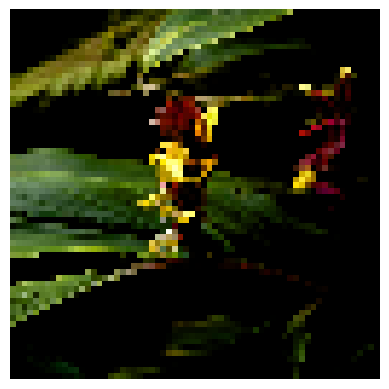

tf.Tensor(
[  101  2023  6546  2038  1037  2843  1997  3756 15829  2008  2298  2200
 27036   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0], shape=(29,), dtype=int32)
[CLS] this flower has a lot of yellow petals that look very fluffy [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


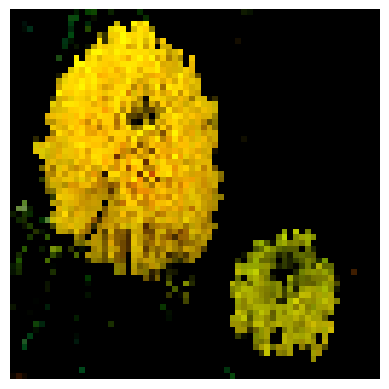

tf.Tensor(
[  101  2023  3492  2417  6546  2038  2317  1998  2417 15829  2006  1996
  5955   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0], shape=(29,), dtype=int32)
[CLS] this pretty red flower has white and red petals on the tip [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


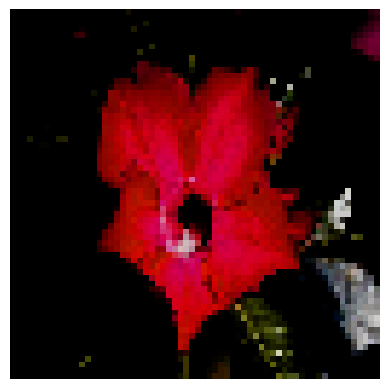

tf.Tensor(
[  101  2023  6546  2003  2317  1999  3609  1998  2038 15829  2008  2024
 21766 28579  2039  1998  2852 29046   102     0     0     0     0     0
     0     0     0     0     0], shape=(29,), dtype=int32)
[CLS] this flower is white in color and has petals that are ruffled up and drooping [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


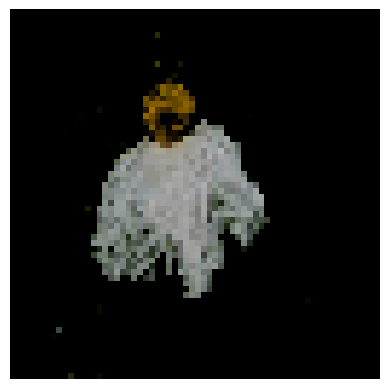

9.499497890472412


In [13]:
# Check result
import time
count = 0
start_time = time.time()
for idx, (image_batch, caption_batch) in enumerate(dataset):
    for image, caption in zip(image_batch, caption_batch):
        # print(caption.numpy().decode('utf-8'))
        print(caption)
        print(tokenizer.decode(caption))
        image = np.clip(image.numpy(), 0, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        count += 1
        break
    if(count == 4): break
end_time = time.time()
print(end_time - start_time)

### Text Encoder

In [14]:
# class TextEncoder(tf.keras.Model):
#     """
#     Encode text (a caption) into hidden representation
#     input: text, which is a list of ids
#     output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
#     """
#     def __init__(self, hparas):
#         super(TextEncoder, self).__init__()
#         self.hparas = hparas
#         self.batch_size = self.hparas['BATCH_SIZE']
        
#         # embedding with tensorflow API
#         self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
#         # RNN, here we use GRU cell, another common RNN cell similar to LSTM
#         self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],
#                               return_sequences=True,
#                               return_state=True,
#                               recurrent_initializer='glorot_uniform')
    
#     def call(self, text, hidden):
#         text = self.embedding(text)
#         output, state = self.gru(text, initial_state = hidden)
#         return output[:, -1, :], state
    
#     def initialize_hidden_state(self):
#         return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))

In [15]:
from transformers import TFBertModel

class TextEncoder(tf.keras.Model):
    """
    Encode text (a caption) into hidden representation
    input: text
    output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.batch_size = self.hparas['BATCH_SIZE']
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, text_ids):
        hidden = self.bert(text_ids)[0]

        return hidden[:, 0, :]

### GAN

In [16]:
# TODO: modify Generator, and DCGAN architecture is different from lab
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        # x-shape
        img_shape = self.hparas['IMAGE_SIZE']
        xh, xw, xc = img_shape
        z_dim = self.hparas['Z_DIM']
        # z-shape
        zh = xh // 4 
        zw = xw // 4
        self.flatten = tf.keras.layers.Flatten()
        self.denseText = tf.keras.layers.Dense(units=self.hparas['DENSE_DIM'])
        self.dense1 = tf.keras.layers.Dense(units=1024)
        # self.dense1 = tf.keras.layers.Dense(units=4*4*512)
        self.dense2 = tf.keras.layers.Dense(units=zh*zw<<8)
        self.convT1 = tf.keras.layers.Conv2DTranspose(
            filters = 256,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.convT2 = tf.keras.layers.Conv2DTranspose(
            filters = 128,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.convT3 = tf.keras.layers.Conv2DTranspose(
            filters = 64,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.convT4 = tf.keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.tanh # TODO: origin sigmoid
        )
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2) # TODO: origin relu
        self.reshape = tf.keras.layers.Reshape(target_shape=(zh, zw, 256))
        # self.reshape = tf.keras.layers.Reshape(target_shape=(4, 4, 512))
        
    def call(self, text, noise_z):
        text = self.flatten(text)
        # text = self.denseText(text)
        # text = self.leaky_relu(text)
        
        x = tf.concat([noise_z, text], axis=1)
        x = self.dense1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dense2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.reshape(x)
        # x = self.convT1(x)
        # x = self.bn2(x)
        # x = self.leaky_relu(x)
        # x = self.convT2(x)
        # x = self.bn3(x)
        # x = self.leaky_relu(x)
        x = self.convT3(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        x = self.convT4(x)
    
        return None, x # TODO: origin return logits, but it seems useless

In [17]:
# discriminator architeture is different from lab
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.denseText = tf.keras.layers.Dense(units=self.hparas['DENSE_DIM'])
        self.denseImage = tf.keras.layers.Dense(units=1024)
        self.denseCombine = tf.keras.layers.Dense(units=128)
        self.denseOut = tf.keras.layers.Dense(1)
        self.conv1 = tf.keras.layers.Conv2D(
            filters = 64,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = self.hparas['IMAGE_SIZE'])
        self.conv2 = tf.keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        )
        self.conv3 = tf.keras.layers.Conv2D(
            filters = 256,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        )
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.bn5 = tf.keras.layers.BatchNormalization()
        self.bn6 = tf.keras.layers.BatchNormalization()
        self.leaky_relu = tf.keras.layers.LeakyReLU()
    
    def call(self, img, text):
        text = self.flatten(text)
        text = self.denseText(text)
        text = self.bn1(text) # TODO: origin no bn
        text = self.leaky_relu(text)
        
        img = self.conv1(img)
        img = self.bn2(img) # TODO: origin no bn
        img = self.leaky_relu(img)
        img = self.conv2(img)
        img = self.bn3(img)
        img = self.leaky_relu(img)
        # img = self.conv3(img)
        # img = self.bn4(img)
        # img = self.leaky_relu(img)
        img = self.flatten(img)
        img = self.denseImage(img)
        img = self.bn6(img)
        img = self.leaky_relu(img)
        
        # concatenate image with paired text
        img_text = tf.concat([img, text], axis=1)
        # img_text = self.denseCombine(img_text)
        logits = self.denseOut(img_text)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [18]:
text_encoder = TextEncoder(hparas)
generator = Generator(hparas)
discriminator = Discriminator(hparas)

text_encoder.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

### Loss Function and Optimization


In [19]:
# # TODO: modify loss function
# Lambda = 10
# def cal_gradient_penalty(real_images, fake_images, text_embed):
#     episolon = tf.random.uniform(shape=[hparas['BATCH_SIZE'], 1, 1, 1], minval=0.0, maxval=1.0)
#     interpolated = episolon * real_images + (1 - episolon) * fake_images

#     with tf.GradientTape() as gt:
#         gt.watch(interpolated)
#         pred, _ = discriminator(interpolated, text_embed, training = True)

#     gradient_c2 = gt.gradient(pred, interpolated)
#     slopes = tf.sqrt(tf.reduce_sum(tf.square(gradient_c2), axis=[1, 2, 3]))
#     gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))
    
#     return gradient_penalty

# # WGAN + GP
# def discriminator_loss(real_logits, fake_logits, gp):
#     real_loss = tf.reduce_mean(real_logits)
#     fake_loss = tf.reduce_mean(fake_logits)
#     total_loss = fake_loss - real_loss + Lambda * gp
#     return total_loss

# def generator_loss(fake_logits):
#     return -tf.reduce_mean(fake_logits)

In [20]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_logits, fake_logits):
    # output value of real image should be 1
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    # output value of fake image should be 0
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
# TODO: WGAN origin optimizers: RMSProp
generator_optimizer = keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = keras.optimizers.SGD(hparas['LR'])
# generator_optimizer = keras.optimizers.RMSprop(hparas['LR'])
# discriminator_optimizer = keras.optimizers.RMSprop(hparas['LR'])

# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir = hparas['CHECKPOINTS_DIR']
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 text_encoder=text_encoder, # TODO: not sure about if we need to save bert weights
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
# @tf.function
# def train_step(real_image, caption, hidden):
#     # random noise for generator
#     noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         text_embed, hidden = text_encoder(caption, hidden)
#         _, fake_image = generator(text_embed, noise)
#         real_logits, real_output = discriminator(real_image, text_embed)
#         fake_logits, fake_output = discriminator(fake_image, text_embed)

#         g_loss = generator_loss(fake_logits)
#         d_loss = discriminator_loss(real_logits, fake_logits)

#     grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
#     grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    
#     return g_loss, d_loss

In [23]:
# TODO: modify train step
@tf.function
def disc_train_step(real_image, caption):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as disc_tape:
        text_embed = text_encoder(caption)
        _, fake_image = generator(text_embed, noise, training=True)
        real_logits, real_output = discriminator(real_image, text_embed, training=True)
        fake_logits, fake_output = discriminator(fake_image, text_embed, training=True)
    
        # gp = cal_gradient_penalty(real_image, fake_image, text_embed)
        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits)
        # d_loss = discriminator_loss(real_logits, fake_logits, gp)
    
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    
    # clipping
    # for v in discriminator.trainable_variables: 
    #     v.assign(tf.clip_by_value(v, -0.01, 0.01))
    
    return g_loss, d_loss


@tf.function
def gen_train_step(real_image, caption):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as gen_tape:
        text_embed = text_encoder(caption)
        _, fake_image = generator(text_embed, noise, training=True)
        real_logits, real_output = discriminator(real_image, text_embed, training=True)
        fake_logits, fake_output = discriminator(fake_image, text_embed, training=True)
    
        # gp = cal_gradient_penalty(real_image, fake_image, text_embed)
        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits)
        # d_loss = discriminator_loss(real_logits, fake_logits, gp)
        
    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    
    return g_loss, d_loss

In [24]:
Train = []
for i in range(hparas['CRITIC']):
    Train.append(disc_train_step)
Train.append(gen_train_step)

In [25]:
# TODO: delete hidden
@tf.function
def test_step(caption, noise):
    text_embed = text_encoder(caption)
    _, fake_image = generator(text_embed, noise)
    return fake_image

### Visualization

In [26]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [27]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(int)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [28]:
# Note: this cell only work for batch_size = 64
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

for i, sent in enumerate(sample_sentence):
    # sample_sentence[i] = sent2IdList(sent)
    sample_sentence[i] = tokenizer.encode(sent, add_special_tokens=True)

max_token_length = max(len(tokens) for tokens in sample_sentence)
paddedCaptionList = tf.keras.preprocessing.sequence.pad_sequences(sample_sentence, padding='post', maxlen=max_token_length)
paddedCaptionList = np.asarray(paddedCaptionList).astype(int)
sample_sentence = sample_generator(paddedCaptionList, hparas['BATCH_SIZE'])

### Training

In [29]:
if not os.path.exists('samples/demo'):
    os.makedirs('samples/demo')

In [30]:
# TODO: modify train
def train(dataset, epochs):
    # hidden state of RNN
    # hidden = text_encoder.initialize_hidden_state()
    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
    
    checkpoint_start_time = time.time()
    for epoch in range(epochs):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
        count = 0
        for image, caption in dataset:
            # captions = [text.numpy().decode('utf-8') for text in caption]
            # g_loss, d_loss = train_step(image, caption, hidden)
            g_loss, d_loss = Train[count](image, caption)
            g_total_loss += g_loss
            d_total_loss += d_loss
            if(count == hparas['CRITIC']): count = 0
            else: count += 1
            
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
            
        # if(epoch % 10 == 0):
        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                    g_total_loss/steps_per_epoch,
                                                                    d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-checkpoint_start_time))
        checkpoint_start_time = time.time()
        
        # save the model
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            for caption in sample_sentence:
                fake_image = test_step(caption, sample_seed)
            save_images(fake_image, [ni, ni], 'samples/demo/train_{:02d}.jpg'.format(epoch))

In [ ]:
train(dataset, hparas['N_EPOCH'])

### 